In [1]:
# import all needed packages 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist

import catboost as cb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

from collections import Counter
import numpy as np

In [2]:
# import the data and turn into dataframe 
fake_news_data = pd.read_csv('../raw_data/train.csv')

In [3]:
# view the data
fake_news_data.head()

,ID,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,barely_true_counts,false_counts,...,sentiment_score,sentiment_magnitude,anger,fear,joy,disgust,sad,speaker_id,list,sentiment_code
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,-0.5,0.5,0.121137,0.008926,0.026096,0.263479,0.531887,_0_,"[0, 1]",_NEG_
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,-0.4,0.8,0.095352,0.124566,0.191357,0.016999,0.102045,_1_,"[0, 1]",_NEG_
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,-0.3,0.3,0.039559,0.024162,0.500384,0.454228,0.052453,_2_,"[1, 0]",_NEG_
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,-0.3,0.3,0.004804,0.194674,0.375055,0.022509,0.383403,_3_,"[0, 1]",_NEG_
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,0.0,0.0,0.044237,0.215996,0.222402,0.045672,0.274343,_4_,"[0, 1]",NaN


In [4]:
# check for null values 
fake_news_data.isnull().sum()

ID                         0
label                      0
statement                  0
subject                    0
speaker                    0
speaker_job             3239
state_info              2486
party_affiliation          0
barely_true_counts         0
false_counts               0
half_true_counts           0
mostly_true_counts         0
pants_on_fire_counts       0
context                  112
sentiment               1541
sentiment_score            0
sentiment_magnitude        0
anger                      0
fear                       0
joy                        0
disgust                    0
sad                        0
speaker_id                 0
list                       0
sentiment_code          1541
dtype: int64

In [5]:
missing = pd.concat([fake_news_data.isnull().sum(), 100 * fake_news_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
ID,0,0.000000
speaker_id,0,0.000000
sad,0,0.000000
disgust,0,0.000000
joy,0,0.000000
fear,0,0.000000
anger,0,0.000000
sentiment_magnitude,0,0.000000
sentiment_score,0,0.000000
list,0,0.000000


In [6]:
# get genral overview of the datatypes the the data has. 
fake_news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11519 entries, 0 to 11518
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    11519 non-null  object 
 1   label                 11519 non-null  object 
 2   statement             11519 non-null  object 
 3   subject               11519 non-null  object 
 4   speaker               11519 non-null  object 
 5   speaker_job           8280 non-null   object 
 6   state_info            9033 non-null   object 
 7   party_affiliation     11519 non-null  object 
 8   barely_true_counts    11519 non-null  float64
 9   false_counts          11519 non-null  float64
 10  half_true_counts      11519 non-null  float64
 11  mostly_true_counts    11519 non-null  float64
 12  pants_on_fire_counts  11519 non-null  float64
 13  context               11407 non-null  object 
 14  sentiment             9978 non-null   object 
 15  sentiment_score    

In [7]:
# This is the feild that we are interseted in 
fake_news_data['statement'].head()

0    Says the Annies List political group supports ...
1    When did the decline of coal start? It started...
2    Hillary Clinton agrees with John McCain "by vo...
3    Health care reform legislation is likely to ma...
4    The economic turnaround started at the end of ...
Name: statement, dtype: object

In [8]:
# the statement feild does not show the full text so, we use set_option to get full text. 
pd.set_option("display.max_colwidth", None)

In [9]:
fake_news_data['statement'].head()

0                                                               Says the Annies List political group supports third-trimester abortions on demand.
1    When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
2                                        Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."
3                                                                   Health care reform legislation is likely to mandate free sex change surgeries.
4                                                                                           The economic turnaround started at the end of my term.
Name: statement, dtype: object

In [10]:
fake_news_data.iloc[0]

ID                                                                                               2635.json
label                                                                                                false
statement               Says the Annies List political group supports third-trimester abortions on demand.
subject                                                                                           abortion
speaker                                                                                       dwayne-bohac
speaker_job                                                                           State representative
state_info                                                                                           Texas
party_affiliation                                                                               republican
barely_true_counts                                                                                     0.0
false_counts                         

In [11]:
# uderstand and get distusbusion of the labels. 
fake_news_data['label'].value_counts()

label
half-true      2361
false          2255
mostly-true    2213
barely-true    1891
true           1845
pants-fire      954
Name: count, dtype: int64

In [12]:
# see the subject that is most talked about
fake_news_data['subject'].value_counts()

subject
health-care                                        434
taxes                                              337
immigration                                        285
education                                          279
elections                                          273
                                                  ... 
elections,labor,workers                              1
health-care,medicare,10-news-tampa-bay               1
environment,government-regulation,public-health      1
baseball,economy,florida                             1
candidates-biography,infrastructure                  1
Name: count, Length: 4190, dtype: int64

In [13]:
# We see that this data mostly focus on Obama and Trump. 
fake_news_data['speaker'].value_counts()

speaker
barack-obama        549
donald-trump        310
hillary-clinton     266
mitt-romney         195
john-mccain         168
                   ... 
d-king                1
burrell-ellis         1
david-segal           1
hilary-treadwell      1
sal-esquivel          1
Name: count, Length: 3125, dtype: int64

In [14]:
# We understand which state is mention the most. 
fake_news_data['state_info'].value_counts()

state_info
Texas             1135
Florida           1114
Wisconsin          799
New York           744
Illinois           624
                  ... 
Qatar                1
New Hampshire        1
Virginia             1
United Kingdom       1
Georgia              1
Name: count, Length: 84, dtype: int64

In [15]:
fake_news_data['party_affiliation'].value_counts()

party_affiliation
republican                      5092
democrat                        3730
none                            1967
organization                     237
independent                      166
newsmaker                         63
libertarian                       46
activist                          43
journalist                        40
columnist                         37
talk-show-host                    29
state-official                    20
labor-leader                      15
business-leader                   10
tea-party-member                  10
education-official                 3
green                              3
constitution-party                 2
liberal-party-canada               1
government-body                    1
Moderate                           1
democratic-farmer-labor            1
ocean-state-tea-party-action       1
county-commissioner                1
Name: count, dtype: int64

In [16]:
fake_news_data['speaker_job'].value_counts()

speaker_job
President                                                                553
U.S. Senator                                                             540
Governor                                                                 432
President-Elect                                                          310
U.S. senator                                                             292
                                                                        ... 
artist                                                                     1
DeKalb County Chief Executive Officer                                      1
Human resources director                                                   1
managing partner at Nexus Homes                                            1
Director, Center for Higher Education, Texas Public Policy Foundation      1
Name: count, Length: 1269, dtype: int64

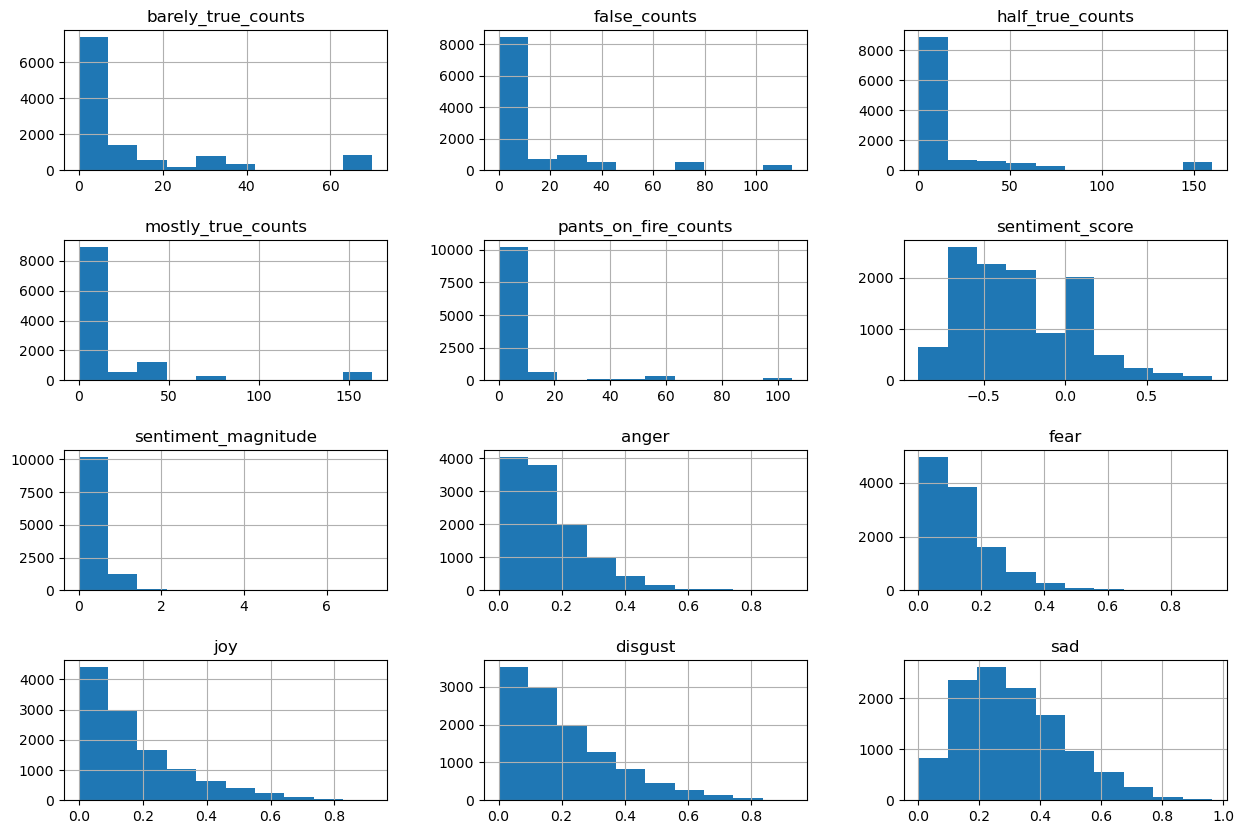

In [17]:
# We ploted all the numeric data to this what feild is usefull and which not. 
fake_news_data.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

In [18]:
# US has 50 states not 84
fake_news_data['state_info'].nunique()

84

In [19]:
fake_news_data['speaker_job'].value_counts()

speaker_job
President                                                                553
U.S. Senator                                                             540
Governor                                                                 432
President-Elect                                                          310
U.S. senator                                                             292
                                                                        ... 
artist                                                                     1
DeKalb County Chief Executive Officer                                      1
Human resources director                                                   1
managing partner at Nexus Homes                                            1
Director, Center for Higher Education, Texas Public Policy Foundation      1
Name: count, Length: 1269, dtype: int64

In [20]:
# make all text lowercase for better training the model
fake_news_data['statement'] = fake_news_data['statement'].str.lower()

In [21]:
# replace "pants-fire", "barely-true" to "false"
fake_news_data['label'] = fake_news_data['label'].replace(['pants-fire', 'barely-true'],'false')
fake_news_data['label'].value_counts()

label
false          5100
half-true      2361
mostly-true    2213
true           1845
Name: count, dtype: int64

In [22]:
# replace "half-true", "mostly-true" to "true"
fake_news_data['label'] = fake_news_data['label'].replace(['half-true', 'mostly-true'],'true')
fake_news_data['label'].value_counts()

label
true     6419
false    5100
Name: count, dtype: int64

In [23]:
fake_news_data[fake_news_data.duplicated()]
fake_news_data = fake_news_data.drop_duplicates()

In [24]:
# remove all the punctuations from the text
fake_news_data['statement'] = fake_news_data['statement'].replace(r'[^\s\w0-9]', '', regex=True)

In [25]:
# some of the states had missed spelled state name or in different format so we change them to same.
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["District of Columbia", "Washington D.C.", "Washington, D.C.", "Washington DC"], "Washington D.C.")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Tex", "Texas"], "Texas")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Washington", "Washington state"], "Washington")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Virginia", "Virgina", "Virgiia"], "Virginia")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Pennsylvania", "PA - Pennsylvania"], "Pennsylvania")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Rhode Island", "Rhode island"], "Rhode Island")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Ohio", "ohio"], "Ohio")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Tennessee", "Tennesse"], "Tennessee")

In [26]:
us_state = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois',
            'Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana',
            'Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon',
            'Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia',
            'Wisconsin','Wyoming','District of Columbia', 'Washington, D.C.']

fake_news_data = fake_news_data[fake_news_data['state_info'].isin(us_state)]

In [27]:
fake_news_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8825 entries, 0 to 11518
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    8825 non-null   object 
 1   label                 8825 non-null   object 
 2   statement             8825 non-null   object 
 3   subject               8825 non-null   object 
 4   speaker               8825 non-null   object 
 5   speaker_job           7506 non-null   object 
 6   state_info            8825 non-null   object 
 7   party_affiliation     8825 non-null   object 
 8   barely_true_counts    8825 non-null   float64
 9   false_counts          8825 non-null   float64
 10  half_true_counts      8825 non-null   float64
 11  mostly_true_counts    8825 non-null   float64
 12  pants_on_fire_counts  8825 non-null   float64
 13  context               8742 non-null   object 
 14  sentiment             7645 non-null   object 
 15  sentiment_score       882

In [28]:
fake_news_scale = fake_news_data[['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'sentiment_score', 'anger', 'fear', 'joy', 'disgust', 'sad']]

In [29]:
# we scale the data for PCA
fake_scale = scale(fake_news_scale)

In [30]:
fake_news_scaled_df = pd.DataFrame(fake_scale, columns=fake_news_scale.columns)
fake_news_scaled_df.head()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,sentiment_score,anger,fear,joy,disgust,sad
0,-0.674013,-0.556981,-0.539551,-0.517016,-0.450707,-0.606948,-0.304710,-1.180478,-0.973070,0.422642,1.304971
1,-0.674013,-0.594711,-0.514468,-0.492173,-0.450707,-0.312807,-0.529394,-0.115020,0.089596,-1.128047,-1.261463
2,2.675746,2.084181,3.473780,3.532304,0.325759,-0.018665,-1.015561,-1.040100,2.076712,1.622708,-1.557559
3,0.043792,-0.255133,-0.037885,-0.045009,-0.278159,0.863759,-0.974798,0.727378,0.289223,-0.947656,-0.232733
4,-0.674013,-0.481519,-0.489385,-0.392803,-0.364433,-0.018665,-0.972210,-0.919577,0.754103,-1.008908,1.705506


In [31]:
fake_news_scaled_df.mean()

barely_true_counts      3.301105e-17
false_counts           -4.267282e-17
half_true_counts       -4.710113e-17
mostly_true_counts      3.502392e-17
pants_on_fire_counts    2.415443e-18
sentiment_score        -5.233459e-18
anger                  -1.272133e-16
fear                   -1.171490e-16
joy                    -1.570038e-17
disgust                 1.851839e-17
sad                     2.999175e-17
dtype: float64

In [32]:
fake_news_scaled_df.std()

barely_true_counts      1.000057
false_counts            1.000057
half_true_counts        1.000057
mostly_true_counts      1.000057
pants_on_fire_counts    1.000057
sentiment_score         1.000057
anger                   1.000057
fear                    1.000057
joy                     1.000057
disgust                 1.000057
sad                     1.000057
dtype: float64

In [33]:
# we apply the PCA on our data and see the result. 
fake_news_pca = PCA().fit(fake_news_scaled_df)

In [34]:
fake_news_pca.explained_variance_ratio_

array([0.36248821, 0.19075018, 0.1172719 , 0.08752494, 0.08167944,
       0.0634569 , 0.05599259, 0.03574434, 0.00260611, 0.00199991,
       0.00048547])

Text(0, 0.5, 'Cumulative ratio variance')

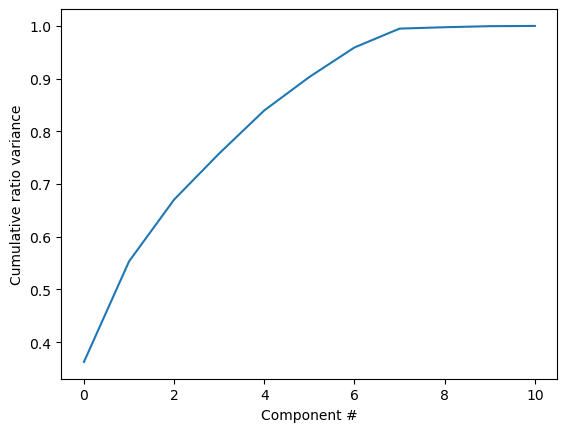

In [35]:
# This tells us that about 4 fetaures are about 0.80 important for the data and about 6 fetaures are 0.90 important. 
plt.plot(fake_news_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')

In [36]:
# create a new column that turns labels into binary values 0 and 1
fake_news_data['num_label'] = fake_news_data['label'].replace({'false' : 0, 'true' : 1})

C:\Users\17326\AppData\Local\Temp\ipykernel_23208\2473114479.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fake_news_data['num_label'] = fake_news_data['label'].replace({'false' : 0, 'true' : 1})


In [37]:
# Select features and target
X = fake_news_data['statement']
y = fake_news_data['num_label']

vectorization = CountVectorizer()
vectorization2 = TfidfVectorizer(min_df=60)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

xv_train2 = vectorization2.fit_transform(X_train)
xv_test2 = vectorization2.transform(X_test)

In [38]:
# we using MultinomialNB to predict words that are most likely to get us a fake news vs words that mostly likely give Real news. 
clf = MultinomialNB().fit(xv_train2, y_train)

In [39]:
words = np.array(vectorization2.get_feature_names_out())

x = np.eye(xv_test2.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

m = []
n = []
s = []
l = []
print("True words\t     P(word | %)")
for w, p in zip(good_words, good_prob):
    m.append(w)
    n.append(1 - np.exp(p))
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("False words\t     P(word | %)")
for w, p in zip(bad_words, bad_prob):
    s.append(w)
    l.append(1 - np.exp(p))
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

True words	     P(word | %)
                half 0.80
                  40 0.77
               three 0.77
             workers 0.76
                weve 0.75
              lowest 0.75
               since 0.74
             average 0.74
             georgia 0.74
                ohio 0.73
False words	     P(word | %)
              barack 0.43
                 gov 0.43
                your 0.43
                  my 0.43
            stimulus 0.43
                 her 0.43
                 she 0.41
           wisconsin 0.40
               scott 0.38
           obamacare 0.34


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'half'),
  Text(1, 0, '40'),
  Text(2, 0, 'three'),
  Text(3, 0, 'workers'),
  Text(4, 0, 'weve'),
  Text(5, 0, 'lowest'),
  Text(6, 0, 'since'),
  Text(7, 0, 'average'),
  Text(8, 0, 'georgia'),
  Text(9, 0, 'ohio')])

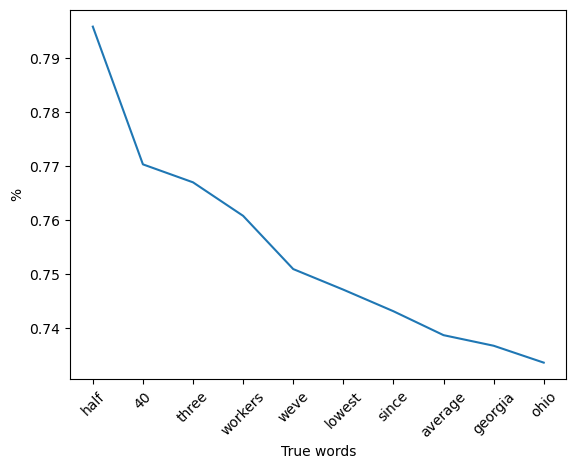

In [40]:
# most words that give True label. 
plt.plot(m, n)
plt.xlabel('True words')
plt.ylabel('%')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'barack'),
  Text(1, 0, 'gov'),
  Text(2, 0, 'your'),
  Text(3, 0, 'my'),
  Text(4, 0, 'stimulus'),
  Text(5, 0, 'her'),
  Text(6, 0, 'she'),
  Text(7, 0, 'wisconsin'),
  Text(8, 0, 'scott'),
  Text(9, 0, 'obamacare')])

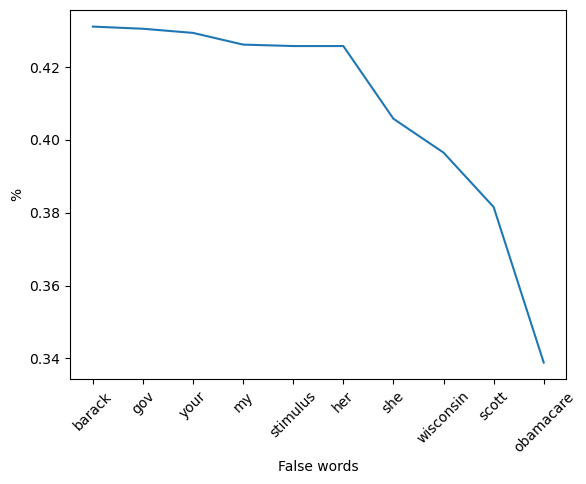

In [41]:
# most words that give False label
plt.plot(s, l)
plt.xlabel('False words')
plt.ylabel('%')
plt.xticks(rotation=45)

In [42]:
# we create a function that tell us for a given a word what is the True vs False difference. 
def extract_words(words):
    for i in fake_news_data['statement']:
        if words in i:
            df = fake_news_data[fake_news_data['statement'].str.contains(words, case=False)]
            return df['label'].value_counts()
        else: 
            None 

In [43]:
# This is for mostly True label. The word "half" has higher propobilty of giving True label
j = extract_words('half')
a = ['True', 'False']
print(j)

label
true     118
false     35
Name: count, dtype: int64


<BarContainer object of 2 artists>

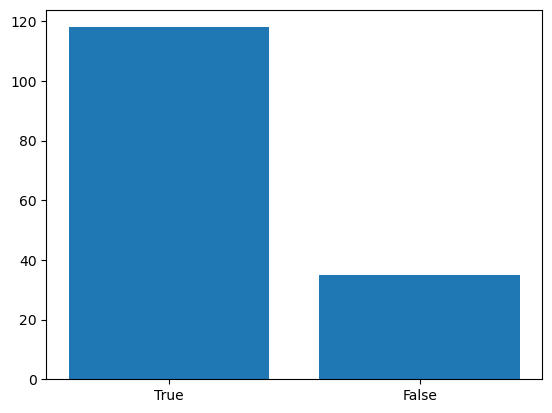

In [44]:
plt.bar(a, j)

In [45]:
# This is for mostly False label. The word "obamacare" has higher propobilty of giving False label
j = extract_words('obamacare')
a = ['False', 'True']
print(j)

label
false    111
true      55
Name: count, dtype: int64


<BarContainer object of 2 artists>

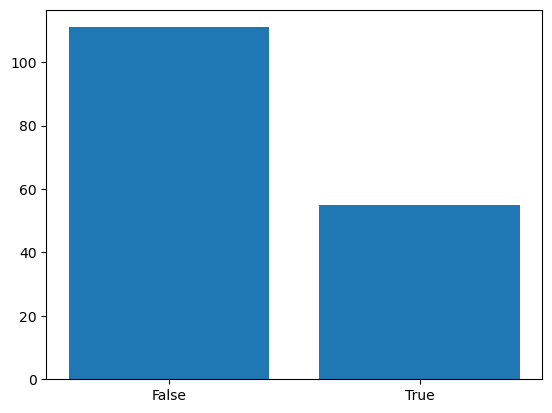

In [46]:
plt.bar(a, j)

In [47]:
# we want to see what features are correlated
corrl = fake_news_data[['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'sentiment_score', 'sentiment_magnitude', 'anger', 'fear', 'joy', 'disgust', 'sad']]
corrl.corr()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,sentiment_score,sentiment_magnitude,anger,fear,joy,disgust,sad
barely_true_counts,1.000000,0.930198,0.909894,0.878463,0.658934,0.036579,0.023111,-0.008105,0.027937,0.026179,-0.001090,-0.028193
false_counts,0.930198,1.000000,0.758189,0.709616,0.853649,0.018957,0.034954,0.000342,0.022931,0.021519,0.007942,-0.020125
half_true_counts,0.909894,0.758189,1.000000,0.987199,0.363028,0.059422,0.000622,-0.035051,0.019036,0.036244,-0.021690,-0.025744
mostly_true_counts,0.878463,0.709616,0.987199,1.000000,0.275220,0.063855,-0.004824,-0.035261,0.017028,0.034201,-0.018067,-0.028617
pants_on_fire_counts,0.658934,0.853649,0.363028,0.275220,1.000000,-0.017588,0.053887,0.023057,0.023146,0.009101,0.019786,-0.004245
sentiment_score,0.036579,0.018957,0.059422,0.063855,-0.017588,1.000000,-0.500247,-0.265495,-0.086879,0.366963,-0.202107,-0.249380
sentiment_magnitude,0.023111,0.034954,0.000622,-0.004824,0.053887,-0.500247,1.000000,0.180842,0.049442,-0.144297,0.113508,0.157024
anger,-0.008105,0.000342,-0.035051,-0.035261,0.023057,-0.265495,0.180842,1.000000,0.077829,-0.401064,0.321444,-0.003058
fear,0.027937,0.022931,0.019036,0.017028,0.023146,-0.086879,0.049442,0.077829,1.000000,-0.243649,-0.115451,0.167413
joy,0.026179,0.021519,0.036244,0.034201,0.009101,0.366963,-0.144297,-0.401064,-0.243649,1.000000,-0.390364,-0.327076


<Axes: >

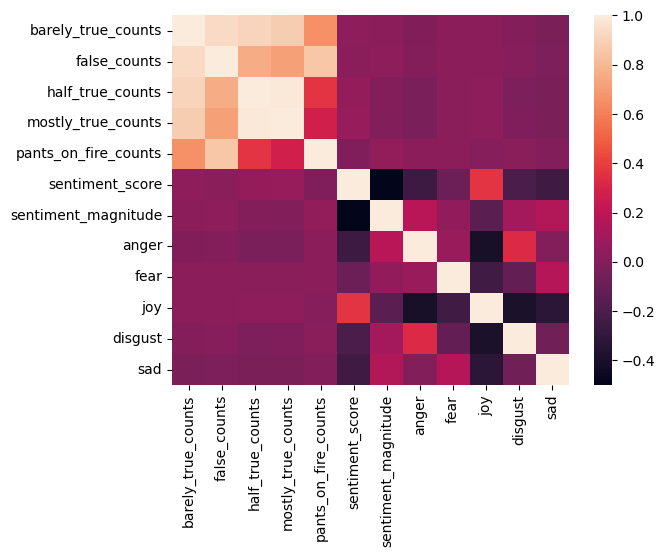

In [48]:
sns.heatmap(corrl.corr())